In [1]:
!pip install -q torch torchvision
!pip install torch torchvision

In [2]:
!pip install tensorflow

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

In [10]:
# Build VGG16 pretrained model
def build_model():
    # Load the VGG16 model pre-trained on ImageNet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)  # 2 classes: mask/no mask

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [11]:
# Data preprocessing and augmentation
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'Face-Mask-Detection-/facemask/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    validation_generator = valid_datagen.flow_from_directory(
        'Face-Mask-Detection-/facemask/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, validation_generator

In [12]:
# Training function
def train_model(model, train_generator, validation_generator):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Model checkpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[early_stopping, checkpoint]
    )

    return history

In [15]:
# Function to preprocess and predict single image
def predict_image(url, model):
    try:
        # Download and open image
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        # Display the image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocess the image
        img = img.resize((224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        prediction = model.predict(img_array)
        class_names = ['with_mask', 'without_mask']
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction)

        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")

        return predicted_class, confidence
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

Found 4296 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 40/135 ━━━━━━━━━━━━━━━━━━━━ 51s 538ms/step - accuracy: 0.5396 - loss: 0.6934

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 528ms/step - accuracy: 0.6317 - loss: 0.6256 - val_accuracy: 0.8867 - val_loss: 0.3728
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 62s 437ms/step - accuracy: 0.8591 - loss: 0.3921 - val_accuracy: 0.9367 - val_loss: 0.2493
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 425ms/step - accuracy: 0.9031 - loss: 0.2901 - val_accuracy: 0.9467 - val_loss: 0.1924
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 84s 433ms/step - accuracy: 0.9163 - loss: 0.2507 - val_accuracy: 0.9600 - val_loss: 0.1600
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 432ms/step - accuracy: 0.9354 - loss: 0.2052 - val_accuracy: 0.9633 - val_loss: 0.1402
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 61s 430ms/step - accuracy: 0.9328 - loss: 0.2011 - val_accuracy: 0.9700 - val_loss: 0.1268
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.9364 - loss: 0.1729 - val_accuracy: 0.9700 - val_loss: 0.1198
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 427ms/step - accuracy: 0.9453 - loss: 0.1593 - val

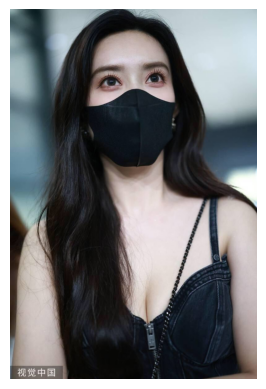

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: with_mask
Confidence: 96.77%


In [16]:
# Main execution
if __name__ == "__main__":
    # Clone repository if not exists
    import os
    import subprocess

    if not os.path.exists('Face-Mask-Detection-'):
        try:
            subprocess.run(['git', 'clone', 'https://github.com/chauhanarpit09/Face-Mask-Detection-.git'],
                         check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error cloning repository: {e}")
            exit(1)

    # Build and train model
    model = build_model()
    train_generator, validation_generator = create_data_generators()
    history = train_model(model, train_generator, validation_generator)

    # Test with user input
    image_url = input("Enter image URL: ")
    predicted_class, confidence = predict_image(image_url, model)